In [12]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils.init import *

問題 1

In [13]:
circuits = []

##################
### EDIT BELOW ###
##################

#講義と同様に4通りの回路を用意し、circuitsに編入する

# Circuit I - H, CX[0, 1], Ry(-π/4)[1]
circuit = QuantumCircuit(2, name='circuit_I')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit II - H, CX[0, 1], Ry(-3π/4)[1]
circuit = QuantumCircuit(2, name='circuit_II')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit III - H, CX[0, 1], Ry(-π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_III')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit IV - H, CX[0, 1], Ry(-3π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_IV')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

##################
### EDIT ABOVE ###
##################

In [14]:
# シミュレータにはショット数の制限がないので、時間の許す限りいくらでも大きい値を使っていい
shots = 10000

# 実習と同じく transpile() - 今は「おまじない」と思ってよい
circuits = transpile(circuits, backend=simulator)
# シミュレータもバックエンドと同じように振る舞うので、runメソッドで回路とショット数を受け取り、ジョブオブジェクトを返す
job = sampler.run(circuits, shots=shots)

# シミュレータから渡されたジョブオブジェクトは実機のジョブと全く同じように扱える
result = job.result()

c_arr = np.zeros(4, dtype=float)

##################
### EDIT BELOW ###
##################

#講義と同様にSamplerの結果からc_arrを計算する

# List to collect the histogram data from the four circuits
counts_list = []

# Extracting the bit sequence counts from the result object
for idx in range(4):
    # get_counts(i) returns the histogram data for circuit i
    counts = result[idx].data.meas.get_counts()
    # Append to list
    counts_list.append(counts)

# enumerate(L)でリストのインデックスと対応する要素に関するループを回せる
for ic, counts in enumerate(counts_list):
    # counts['00'] でなく counts.get('00', 0) - 上のテキストを参照
    c_arr[ic] = counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)

##################
### EDIT ABOVE ###
##################

c_arr /= shots

s_val = c_arr[0] - c_arr[1] + c_arr[2] + c_arr[3]
print('S =', s_val)

S = 2.8268


問題 2

In [15]:
# Consider 20 points each for theta and phi (400 points total)
ntheta = 20
nchi = 20

thetas = np.linspace(0., np.pi, ntheta)
chis = np.linspace(0., np.pi, nchi)

# Construct a circuit for each (theta, chi) pair
circuits = []
# np.ndindex returns an iterator over a multi-dimensional array
# -> idx = (0, 0), (0, 1), ..., (1, 0), (1, 1), ...
for idx in np.ndindex(ntheta, nchi):
    theta = thetas[idx[0]]
    chi = chis[idx[1]]

    circuit = QuantumCircuit(2, name=f'circuit_{idx[0]}_{idx[1]}')

    # Create a circuit that forms a Bell state, applies Ry gates with theta and chi
    # as arguments, and measures the state

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?
    circuit.ry(theta, 0)
    circuit.ry(chi, 1)

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    circuits.append(circuit)

# Execute all circuits in Sampler and retrieve the results
shots = 10000
circuits = transpile(circuits, backend=simulator)
job = sampler.run(circuits, shots=shots)
result = job.result()

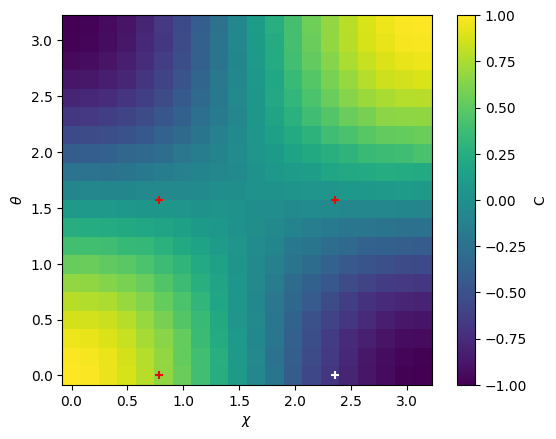

In [16]:
# Compute the C values for each (theta, chi)
c_values = np.zeros((ntheta, nchi), dtype=float)
for icirc, idx in enumerate(np.ndindex(ntheta, nchi)):
    # This is the counts dict for the (theta, chi) pair
    counts = result[icirc].data.meas.get_counts()

    ##################
    ### EDIT BELOW ###
    ##################

    #c_values[idx] = ?
    c_values[idx] += counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)
    c_values[idx] /= sum(counts.values())

    ##################
    ### EDIT ABOVE ###
    ##################

# Making a 2D plot using imshow()
# The theta dimension of c_values must be reversed because imshow() puts the origin at the top left corner
dtheta = (thetas[1] - thetas[0]) * 0.5
dchi = (chis[1] - chis[0]) * 0.5
plt.imshow(c_values[::-1], extent=(chis[0] - dchi, chis[-1] + dchi, thetas[0] - dtheta, thetas[-1] + dtheta))
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\theta$')
plt.colorbar(label='C')
# Place markers at theta and chi values that realize |S| = 2 sqrt(2)
plt.scatter([np.pi / 4., np.pi / 4., 3. * np.pi / 4.], [0., np.pi / 2., np.pi / 2.], c='red', marker='+')
plt.scatter([3. * np.pi / 4.], [0.], c='white', marker='+')

問題 3

In [17]:
# Construct a circuit for each (theta, chi) pair
circuits_ghz = []
# np.ndindex returns an iterator over a multi-dimensional array
# -> idx = (0, 0), (0, 1), ..., (1, 0), (1, 1), ...
for idx in np.ndindex(ntheta, nchi):
    theta = thetas[idx[0]]
    chi = chis[idx[1]]

    circuit = QuantumCircuit(3, name=f'circuit_{idx[0]}_{idx[1]}')

    # Create a circuit that forms a GHZ state and then measures the two qubits
    # along theta and chi bases

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?
    circuit.ry(theta, 0)
    circuit.ry(chi, 1)

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    circuits_ghz.append(circuit)

# Execute all circuits in qasm_simulator and retrieve the results
circuits_ghz = transpile(circuits_ghz, backend=simulator)
sim_job_ghz = sampler.run(circuits_ghz, shots=shots)
result_ghz = sim_job_ghz.result()

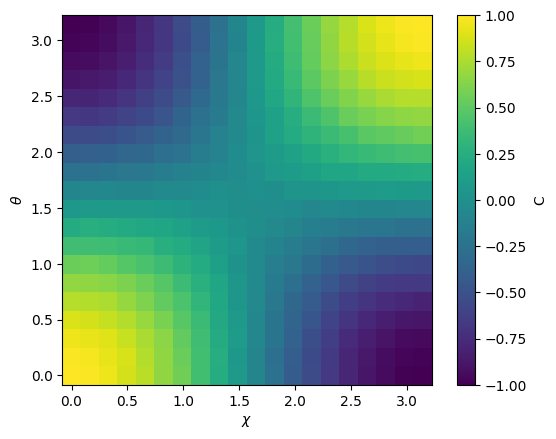

In [18]:
def counts_ignoring_qubit2(counts, bitstring):
    """Add the counts of cases where qubit C is 0 and 1"""

    return counts.get(f'0{bitstring}', 0) + counts.get(f'1{bitstring}', 0)

# Compute the C values for each (theta, chi)
c_values_ghz = np.zeros((ntheta, nchi), dtype=float)
for icirc, idx in enumerate(np.ndindex(ntheta, nchi)):
    # This is the counts dict for the (theta, chi) pair
    counts = result_ghz[icirc].data.meas.get_counts()

    ##################
    ### EDIT BELOW ###
    ##################

    #c_values_ghz[idx] = ?
    c_values_ghz[idx] += counts_ignoring_qubit2(counts, '00') + counts_ignoring_qubit2(counts, '11') - counts_ignoring_qubit2(counts, '01') - counts_ignoring_qubit2(counts, '10')
    c_values_ghz[idx] /= sum(counts.values())

    ##################
    ### EDIT ABOVE ###
    ##################

# Making a 2D plot using imshow()
# The theta dimension of c_values must be reversed because imshow() puts the origin at the top left corner
plt.imshow(c_values_ghz[::-1], extent=(chis[0] - dchi, chis[-1] + dchi, thetas[0] - dtheta, thetas[-1] + dtheta))
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\theta$')
plt.colorbar(label='C')

In [19]:
max_abs_s = 0.

# Use ndindex to iterate over all index combinations
for ikappa, ilambda, imu, inu in np.ndindex(ntheta, nchi, ntheta, nchi):
    abs_s = abs(c_values_ghz[ikappa, ilambda] - c_values_ghz[ikappa, inu] + c_values_ghz[imu, ilambda] + c_values_ghz[imu, inu])
    max_abs_s = max(abs_s, max_abs_s)

print(f'max |S| = {max_abs_s}')

max |S| = 2.0370000000000004
